# Exploratory Data Analysis (EDA) for Crypto Volatility Features

This notebook performs exploratory data analysis on the computed features to:
1. Understand the distribution of features
2. Visualize time series patterns
3. Determine an appropriate spike threshold (τ) for volatility classification

## Data Sources
- `data/processed/features.parquet`: Features computed from live Kafka stream
- `data/processed/features_replay.parquet`: Features recomputed from raw NDJSON files (for validation)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Find project root - try multiple locations
possible_roots = [
    Path.cwd(),  # Current directory
    Path.cwd().parent,  # One level up (if running from notebooks/)
    Path.cwd().parent.parent,  # Two levels up
]

project_root = None
for root in possible_roots:
    if (root / "data" / "processed").exists():
        project_root = root
        break

if project_root is None:
    # Fallback: use current directory
    project_root = Path.cwd()
    print(f"⚠ Warning: Could not find project root, using: {project_root}")

print(f"Project root: {project_root}")
print(f"Data directory: {project_root / 'data' / 'processed'}")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully")


Project root: /Users/smridhipatwari/Desktop/AIM Carnegie Mellon/Courses /Operationalizing AI/Assignments/crypto-volatility-project
Data directory exists: True
Libraries imported successfully


## 1. Load Data

Load features from Parquet files. We'll start with the live features and optionally compare with replay features.


In [20]:
# Load live features (use project root path)
features_path = project_root / "data" / "processed" / "features.parquet"
print(f"Looking for features at: {features_path}")
print(f"File exists: {features_path.exists()}")

if not features_path.exists():
    # Try alternative locations
    alt_paths = [
        Path("data/processed/features.parquet"),
        Path("../data/processed/features.parquet"),
        Path.cwd() / "data" / "processed" / "features.parquet",
    ]
    for alt in alt_paths:
        if alt.exists():
            features_path = alt
            print(f"Found features at: {features_path}")
            break
    else:
        raise FileNotFoundError(f"Could not find features.parquet. Tried: {[features_path] + alt_paths}")

df = pd.read_parquet(features_path)

print(f"\n✓ Loaded {len(df)} feature rows from {features_path}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nShape: {df.shape}")

# Optionally load replay features for comparison
replay_path = project_root / "data" / "processed" / "features_replay.parquet"
if not replay_path.exists():
    replay_path = Path("data/processed/features_replay.parquet")
if not replay_path.exists():
    replay_path = Path("../data/processed/features_replay.parquet")

try:
    if replay_path.exists():
        df_replay = pd.read_parquet(replay_path)
        print(f"\n✓ Also loaded {len(df_replay)} replay feature rows")
        print(f"  Replay date range: {df_replay['timestamp'].min()} to {df_replay['timestamp'].max()}")
    else:
        df_replay = None
        print("\n⚠ Replay features not found, skipping comparison")
except Exception as e:
    print(f"\n⚠ Could not load replay features: {e}")
    df_replay = None


Looking for features at: /Users/smridhipatwari/Desktop/AIM Carnegie Mellon/Courses /Operationalizing AI/Assignments/crypto-volatility-project/data/processed/features.parquet
File exists: True

✓ Loaded 3351 feature rows from /Users/smridhipatwari/Desktop/AIM Carnegie Mellon/Courses /Operationalizing AI/Assignments/crypto-volatility-project/data/processed/features.parquet
Date range: 2025-11-17T03:28:19.747394+00:00 to 2025-11-17T03:39:03.819247+00:00

Columns: ['timestamp', 'product_id', 'midprice', 'midprice_return', 'rolling_vol', 'spread', 'trade_intensity']

Shape: (3351, 7)

✓ Also loaded 59840 replay feature rows
  Replay date range: 2025-11-17T00:37:35.405255+00:00 to 2025-11-17T03:43:43.588341+00:00


## 2. Basic Data Exploration

First, let's examine the structure and basic statistics of our features.


In [21]:
# Display first few rows
print("First 5 rows:")
display(df.head())

print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
display(df.describe())


First 5 rows:


,timestamp,product_id,midprice,midprice_return,rolling_vol,spread,trade_intensity
0,2025-11-17T03:28:19.747394+00:00,BTC-USD,95347.615,0.000000e+00,NaN,0.01,2
1,2025-11-17T03:28:20.027551+00:00,BTC-USD,95347.615,0.000000e+00,0.000000e+00,0.01,3
2,2025-11-17T03:28:20.246869+00:00,BTC-USD,95347.595,-2.097588e-07,1.211043e-07,0.01,4
3,2025-11-17T03:28:20.475084+00:00,BTC-USD,95347.595,0.000000e+00,1.048794e-07,0.01,5
4,2025-11-17T03:28:20.478981+00:00,BTC-USD,95347.295,-3.146382e-06,1.386631e-06,0.59,6



Summary Statistics:


,midprice,midprice_return,rolling_vol,spread,trade_intensity
count,3351.000000,3.351000e+03,3350.000000,3351.000000,3351.000000
mean,95333.951079,-6.126042e-07,0.000019,0.366138,59.489406
std,68.626523,2.059940e-05,0.000008,1.042240,4.433770
min,95151.905000,-3.512900e-04,0.000000,0.010000,2.000000
25%,95258.255000,0.000000e+00,0.000013,0.010000,60.000000
50%,95355.375000,0.000000e+00,0.000017,0.010000,60.000000
75%,95391.145000,0.000000e+00,0.000023,0.010000,60.000000
max,95441.975000,2.141348e-04,0.000052,9.900000,60.000000


In [11]:
# Data types and missing values
print("Data Types:")
print(df.dtypes)
print("\n" + "="*80)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*80)
print("Product IDs:")
print(df['product_id'].value_counts())


Data Types:
timestamp           object
product_id          object
midprice           float64
midprice_return    float64
rolling_vol        float64
spread             float64
trade_intensity      int64
dtype: object

Missing Values:
timestamp          0
product_id         0
midprice           0
midprice_return    0
rolling_vol        1
spread             0
trade_intensity    0
dtype: int64

Product IDs:
product_id
BTC-USD    3351
Name: count, dtype: int64


## 3. Time Series Visualization

Visualize how key features evolve over time, particularly midprice and rolling volatility.


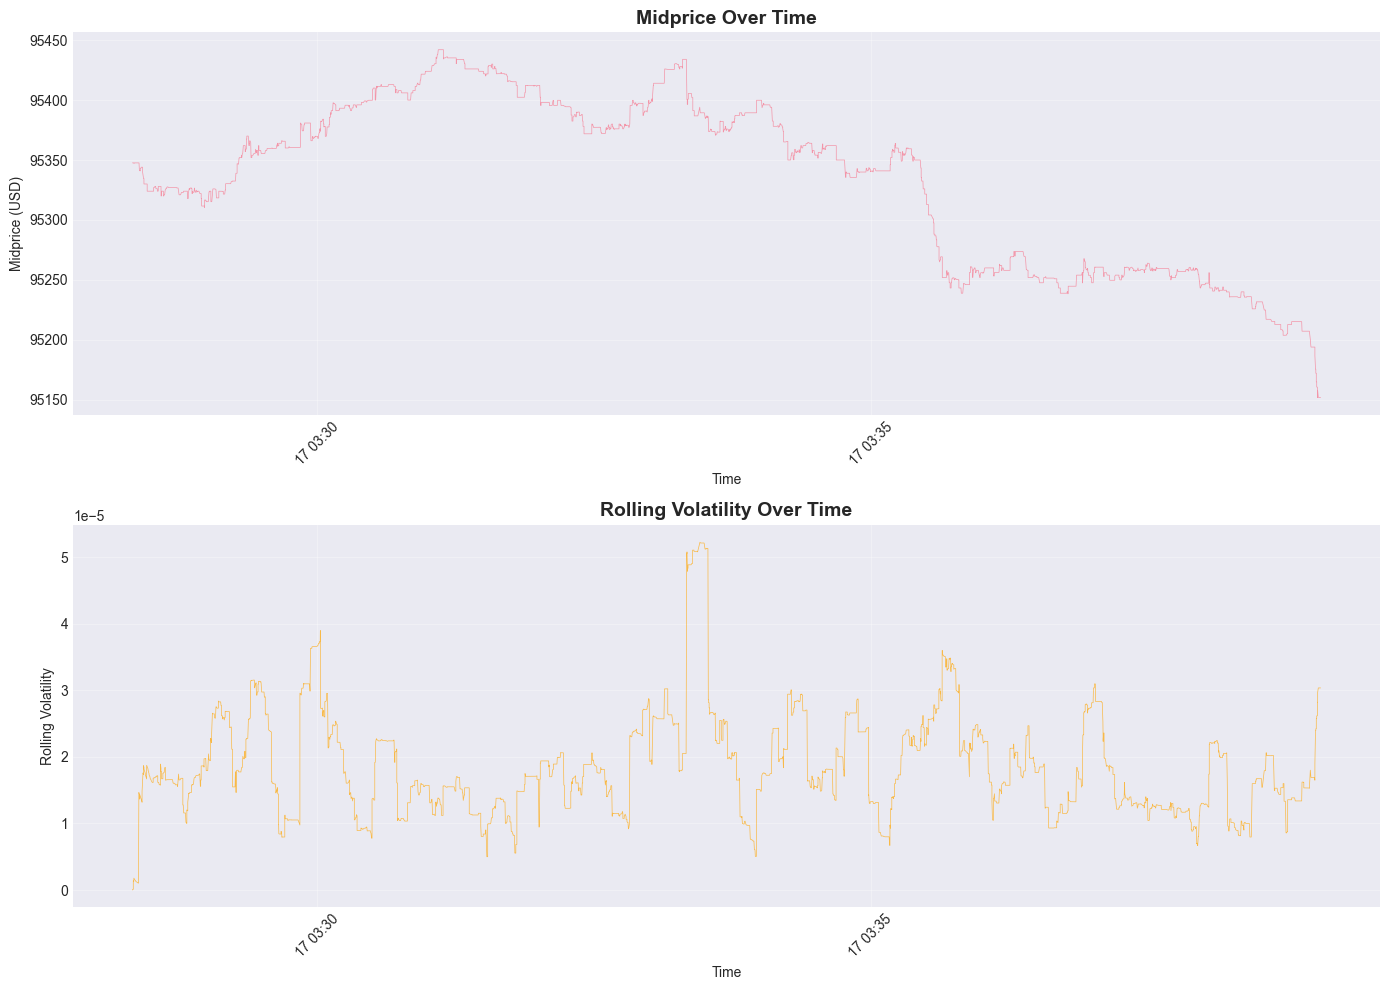

Midprice range: $95151.90 - $95441.98
Rolling vol range: 0.000000 - 0.000052


In [12]:
# Convert timestamp to datetime for plotting
df['datetime'] = pd.to_datetime(df['timestamp'])

# Create time series plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Midprice over time
axes[0].plot(df['datetime'], df['midprice'], linewidth=0.5, alpha=0.7)
axes[0].set_title('Midprice Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Midprice (USD)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Rolling Volatility over time
axes[1].plot(df['datetime'], df['rolling_vol'], linewidth=0.5, alpha=0.7, color='orange')
axes[1].set_title('Rolling Volatility Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Rolling Volatility')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Midprice range: ${df['midprice'].min():.2f} - ${df['midprice'].max():.2f}")
print(f"Rolling vol range: {df['rolling_vol'].min():.6f} - {df['rolling_vol'].max():.6f}")


## 4. Distribution Analysis

Examine the distribution of rolling volatility to understand its characteristics and identify potential spike thresholds.


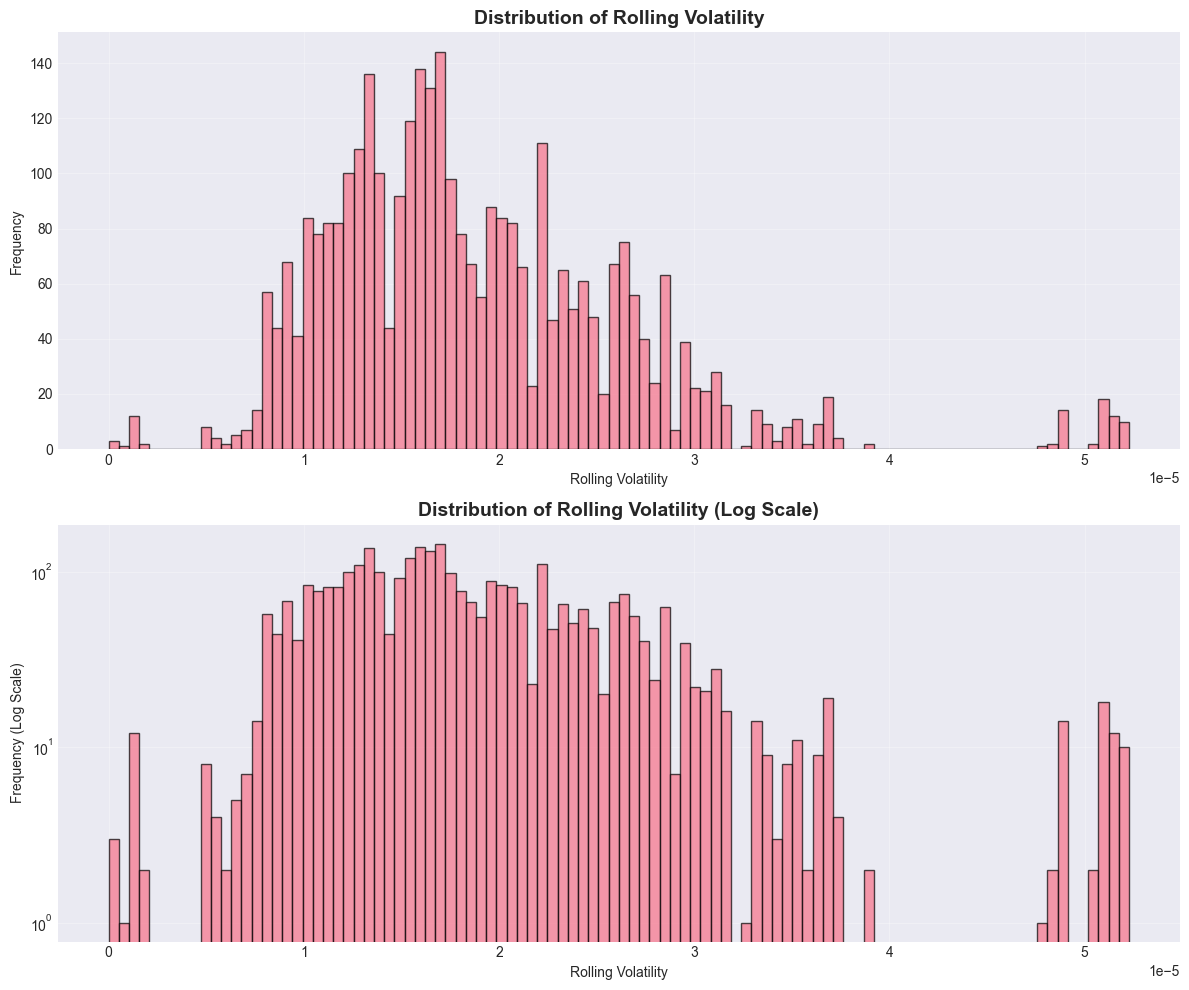

In [22]:
# Remove NaN values for plotting
rolling_vol_clean = df['rolling_vol'].dropna()

# Create histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(rolling_vol_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Rolling Volatility', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rolling Volatility')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log-scale histogram (to better see tail behavior)
axes[1].hist(rolling_vol_clean, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_yscale('log')
axes[1].set_title('Distribution of Rolling Volatility (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rolling Volatility')
axes[1].set_ylabel('Frequency (Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Rolling Volatility Percentiles:
 50.0th percentile: 0.00001710
 75.0th percentile: 0.00002311
 90.0th percentile: 0.00002828
 95.0th percentile: 0.00003099
 97.5th percentile: 0.00003655
 99.0th percentile: 0.00005089
 99.5th percentile: 0.00005128
 99.9th percentile: 0.00005216


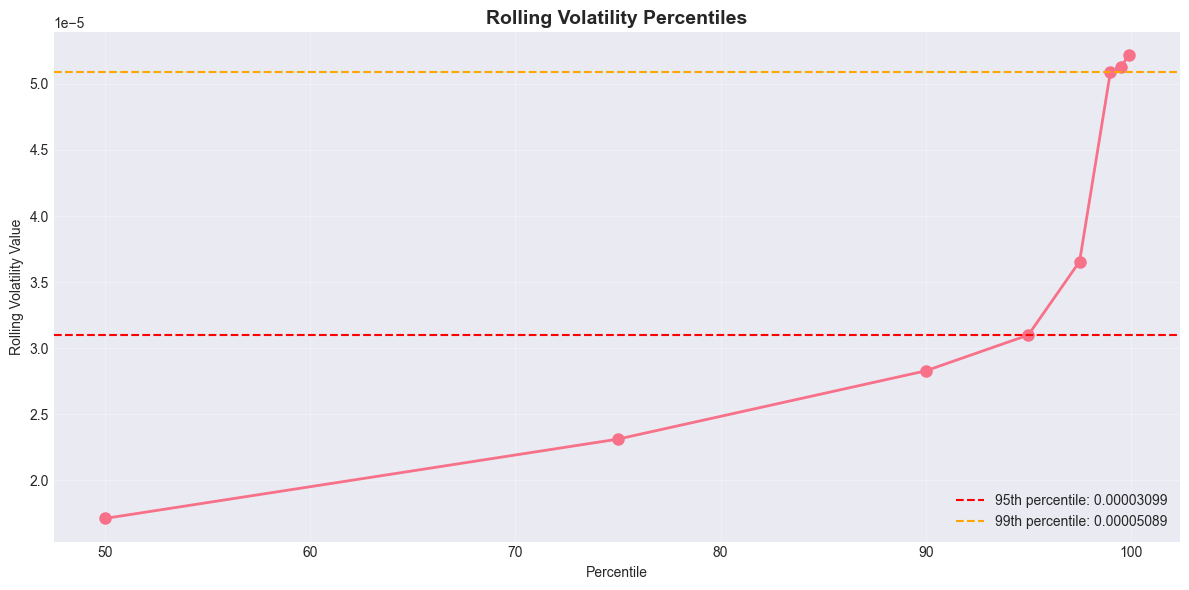

In [23]:
# Calculate percentiles
percentiles = [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]
percentile_values = np.percentile(rolling_vol_clean, percentiles)

print("Rolling Volatility Percentiles:")
print("="*50)
for p, v in zip(percentiles, percentile_values):
    print(f"{p:5.1f}th percentile: {v:.8f}")

# Create percentile plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(percentiles, percentile_values, marker='o', linewidth=2, markersize=8)
ax.set_title('Rolling Volatility Percentiles', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentile')
ax.set_ylabel('Rolling Volatility Value')
ax.grid(True, alpha=0.3)
ax.axhline(y=percentile_values[percentiles.index(95)], color='r', linestyle='--', 
           label=f'95th percentile: {percentile_values[percentiles.index(95)]:.8f}')
ax.axhline(y=percentile_values[percentiles.index(99)], color='orange', linestyle='--', 
           label=f'99th percentile: {percentile_values[percentiles.index(99)]:.8f}')
ax.legend()
plt.tight_layout()
plt.show()


## 5. Spike Threshold Selection

Based on the percentile analysis above, we need to select a threshold (τ) that identifies "spike" events in volatility.

**TODO: Add narrative explaining:**
- Why we're using percentiles to define spikes
- The trade-off between sensitivity (lower threshold) vs specificity (higher threshold)
- How this threshold will be used in label generation (1 if σ_future >= τ; else 0)


In [24]:
# Candidate thresholds based on percentiles
candidate_thresholds = {
    '90th': np.percentile(rolling_vol_clean, 90),
    '95th': np.percentile(rolling_vol_clean, 95),
    '97.5th': np.percentile(rolling_vol_clean, 97.5),
    '99th': np.percentile(rolling_vol_clean, 99),
    '99.5th': np.percentile(rolling_vol_clean, 99.5),
    '99.9th': np.percentile(rolling_vol_clean, 99.9),
}

print("Candidate Thresholds (τ):")
print("="*50)
for name, value in candidate_thresholds.items():
    count_above = (rolling_vol_clean >= value).sum()
    pct_above = (count_above / len(rolling_vol_clean)) * 100
    print(f"{name:8s}: {value:.8f} ({count_above:6d} samples, {pct_above:5.2f}%)")

# Select default threshold (95th percentile as a reasonable starting point)
# TODO: Adjust based on domain knowledge and model performance
DEFAULT_THRESHOLD = candidate_thresholds['95th']
print("\n" + "="*50)
print(f"Selected Default Threshold (τ): {DEFAULT_THRESHOLD:.8f} (95th percentile)")
print("="*50)


Candidate Thresholds (τ):
90th    : 0.00002828 (   336 samples, 10.03%)
95th    : 0.00003099 (   168 samples,  5.01%)
97.5th  : 0.00003655 (    84 samples,  2.51%)
99th    : 0.00005089 (    34 samples,  1.01%)
99.5th  : 0.00005128 (    18 samples,  0.54%)
99.9th  : 0.00005216 (     4 samples,  0.12%)

Selected Default Threshold (τ): 0.00003099 (95th percentile)


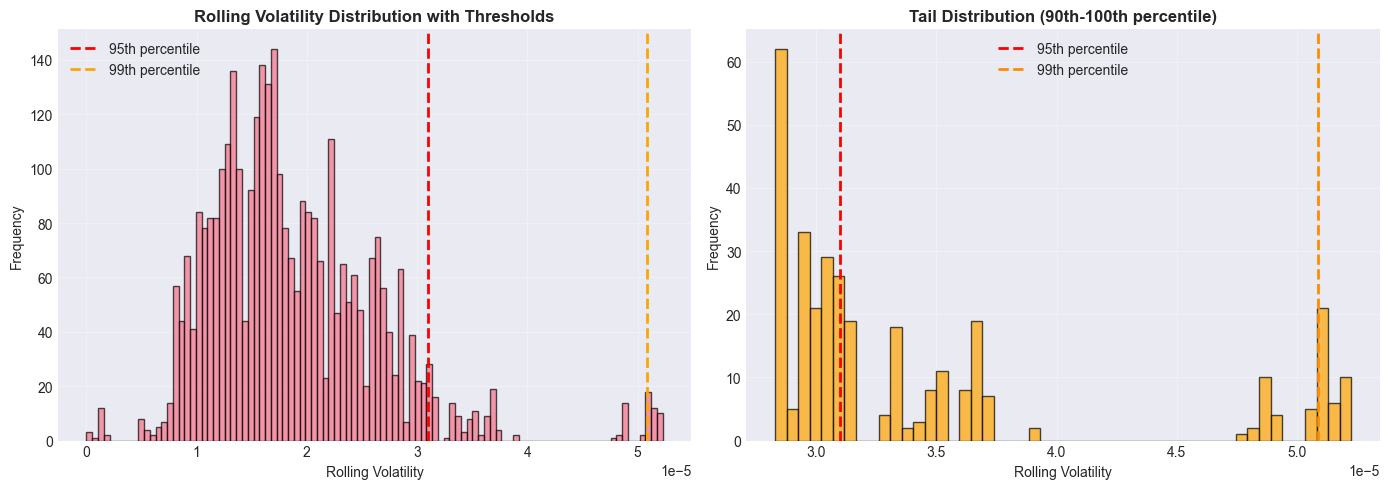

In [25]:
# Visualize threshold on distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with threshold lines
axes[0].hist(rolling_vol_clean, bins=100, edgecolor='black', alpha=0.7)
for name, threshold in [('95th', candidate_thresholds['95th']), 
                        ('99th', candidate_thresholds['99th'])]:
    axes[0].axvline(x=threshold, color='r' if name == '95th' else 'orange', 
                    linestyle='--', linewidth=2, label=f'{name} percentile')
axes[0].set_title('Rolling Volatility Distribution with Thresholds', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rolling Volatility')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom into tail region
tail_data = rolling_vol_clean[rolling_vol_clean >= np.percentile(rolling_vol_clean, 90)]
axes[1].hist(tail_data, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=candidate_thresholds['95th'], color='r', linestyle='--', 
                linewidth=2, label='95th percentile')
axes[1].axvline(x=candidate_thresholds['99th'], color='darkorange', linestyle='--', 
                linewidth=2, label='99th percentile')
axes[1].set_title('Tail Distribution (90th-100th percentile)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Rolling Volatility')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Additional Feature Analysis

Explore relationships between features and identify any patterns or anomalies.


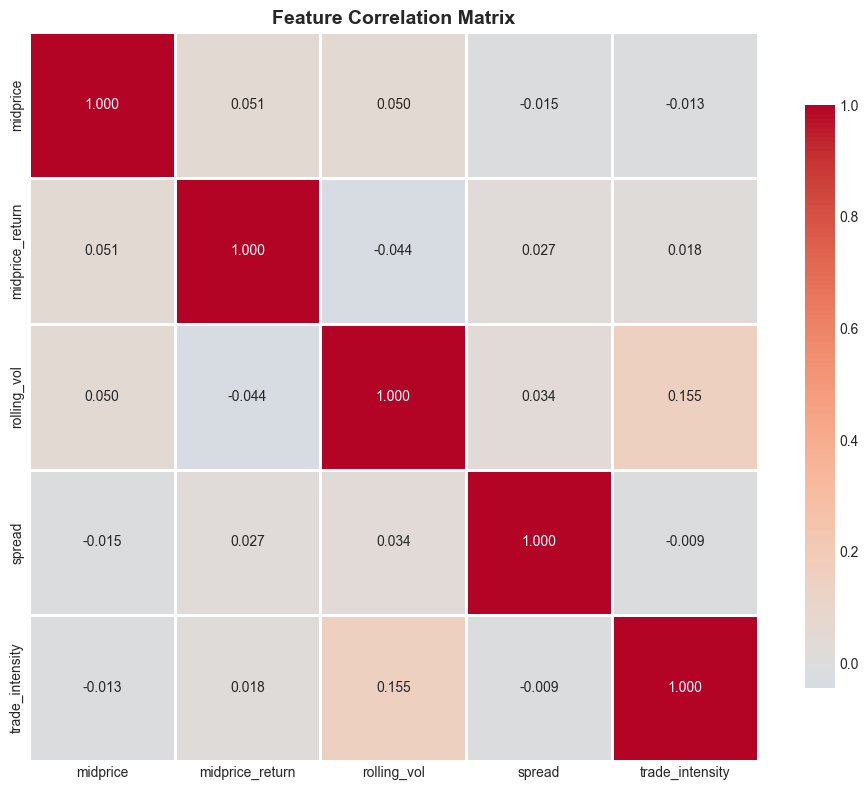

In [17]:
# Correlation matrix
numeric_cols = ['midprice', 'midprice_return', 'rolling_vol', 'spread', 'trade_intensity']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


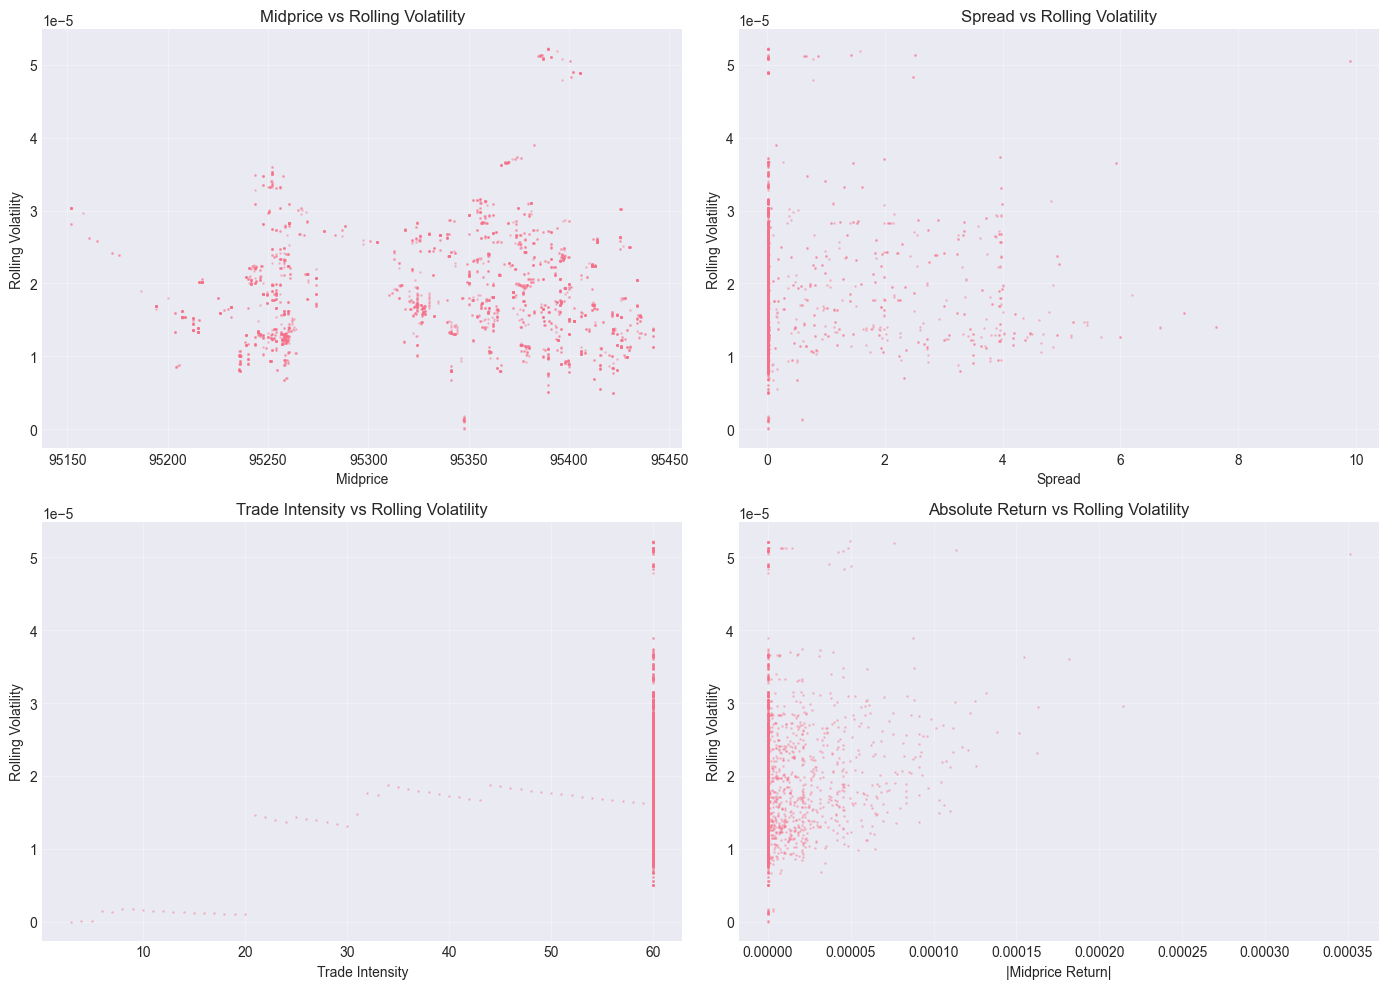

In [26]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Midprice vs Rolling Vol
axes[0, 0].scatter(df['midprice'], df['rolling_vol'], alpha=0.3, s=1)
axes[0, 0].set_xlabel('Midprice')
axes[0, 0].set_ylabel('Rolling Volatility')
axes[0, 0].set_title('Midprice vs Rolling Volatility')
axes[0, 0].grid(True, alpha=0.3)

# Spread vs Rolling Vol
axes[0, 1].scatter(df['spread'], df['rolling_vol'], alpha=0.3, s=1)
axes[0, 1].set_xlabel('Spread')
axes[0, 1].set_ylabel('Rolling Volatility')
axes[0, 1].set_title('Spread vs Rolling Volatility')
axes[0, 1].grid(True, alpha=0.3)

# Trade Intensity vs Rolling Vol
axes[1, 0].scatter(df['trade_intensity'], df['rolling_vol'], alpha=0.3, s=1)
axes[1, 0].set_xlabel('Trade Intensity')
axes[1, 0].set_ylabel('Rolling Volatility')
axes[1, 0].set_title('Trade Intensity vs Rolling Volatility')
axes[1, 0].grid(True, alpha=0.3)

# Midprice Return vs Rolling Vol
axes[1, 1].scatter(df['midprice_return'].abs(), df['rolling_vol'], alpha=0.3, s=1)
axes[1, 1].set_xlabel('|Midprice Return|')
axes[1, 1].set_ylabel('Rolling Volatility')
axes[1, 1].set_title('Absolute Return vs Rolling Volatility')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Summary and Next Steps

**TODO: Add narrative summarizing:**
- Key findings from the EDA
- Rationale for chosen threshold (τ)
- How this threshold will be used in the feature specification
- Next steps for model development

### Selected Threshold
Based on the analysis above, the selected threshold is:
- **τ = {DEFAULT_THRESHOLD:.8f}** (95th percentile)

This threshold will be used to generate binary labels:
- **Label = 1** if future volatility (σ_future) >= τ
- **Label = 0** otherwise


In [19]:
# Final summary
print("="*80)
print("EDA SUMMARY")
print("="*80)
print(f"Total samples: {len(df):,}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nRolling Volatility Statistics:")
print(f"  Mean: {rolling_vol_clean.mean():.8f}")
print(f"  Median: {rolling_vol_clean.median():.8f}")
print(f"  Std: {rolling_vol_clean.std():.8f}")
print(f"  Min: {rolling_vol_clean.min():.8f}")
print(f"  Max: {rolling_vol_clean.max():.8f}")
print(f"\nSelected Threshold (τ): {DEFAULT_THRESHOLD:.8f}")
print(f"  Percentile: 95th")
print(f"  Samples above threshold: {(rolling_vol_clean >= DEFAULT_THRESHOLD).sum():,} ({(rolling_vol_clean >= DEFAULT_THRESHOLD).sum() / len(rolling_vol_clean) * 100:.2f}%)")
print("="*80)


EDA SUMMARY
Total samples: 3,351
Date range: 2025-11-17 03:28:19.747394+00:00 to 2025-11-17 03:39:03.819247+00:00

Rolling Volatility Statistics:
  Mean: 0.00001872
  Median: 0.00001710
  Std: 0.00000784
  Min: 0.00000000
  Max: 0.00005227

Selected Threshold (τ): 0.00003099
  Percentile: 95th
  Samples above threshold: 168 (5.01%)
